# xSFR - Expected Shot from Recovery

Importing necessary libraries

In [1]:
import pandas as pd
import numpy as np
import json
import os
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, roc_auc_score
from sklearn import metrics
from statsmodels.stats.outliers_influence import variance_inflation_factor





/Users/jedrzejsarna/anaconda3/lib/python3.11/site-packages/pandas/core/arrays/masked.py:60: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.5' currently installed).
  from pandas.core import (


In [2]:
# Open the file and load the data
file_name = "../events/events_England.json"
f = open(file_name)
data = json.load(f)
df = pd.DataFrame(data)


In [3]:
df.head()

,eventId,subEventName,tags,playerId,positions,matchId,eventName,teamId,matchPeriod,eventSec,subEventId,id
0,8,Simple pass,[{'id': 1801}],25413,"[{'y': 49, 'x': 49}, {'y': 78, 'x': 31}]",2499719,Pass,1609,1H,2.758649,85,177959171
1,8,High pass,[{'id': 1801}],370224,"[{'y': 78, 'x': 31}, {'y': 75, 'x': 51}]",2499719,Pass,1609,1H,4.946850,83,177959172
2,8,Head pass,[{'id': 1801}],3319,"[{'y': 75, 'x': 51}, {'y': 71, 'x': 35}]",2499719,Pass,1609,1H,6.542188,82,177959173
3,8,Head pass,[{'id': 1801}],120339,"[{'y': 71, 'x': 35}, {'y': 95, 'x': 41}]",2499719,Pass,1609,1H,8.143395,82,177959174
4,8,Simple pass,[{'id': 1801}],167145,"[{'y': 95, 'x': 41}, {'y': 88, 'x': 72}]",2499719,Pass,1609,1H,10.302366,85,177959175


# Define the initial necessary functions

### Firstly cosmetic functions for event data

In [4]:
# Tag ids, labels and descriptions are from https://support.wyscout.com/matches-wyid-events
tags = [
    [101, "Goal", "Goal"],
    [102, "own_goal", "Own goal"],
    [301, "assist", "Assist"],
    [302, "keyPass", "Key pass"],
    [1901, "counter_attack", "Counter attack"],
    [401, "Left", "Left foot"],
    [402, "Right", "Right foot"],
    [403, "head/body", "Head/body"],
    [1101, "direct", "Direct"],
    [1102, "indirect", "Indirect"],
    [2001, "dangerous_ball_lost", "Dangerous ball lost"],
    [2101, "blocked", "Blocked"],
    [801, "high", "High"],
    [802, "low", "Low"],
    [1401, "interception", "Interception"],
    [1501, "clearance", "Clearance"],
    [201, "opportunity", "Opportunity"],
    [1301, "Feint", "Feint"],
    [1302, "missed ball", "Missed ball"],
    [501, "free_space_r", "Free space right"],
    [502, "free_space_l", "Free space left"],
    [503, "take_on_l", "Take on left"],
    [504, "take_on_r", "Take on right"],
    [1601, "sliding_tackle", "Sliding tackle"],
    [601, "anticipated", "Anticipated"],
    [602, "anticipation", "Anticipation"],
    [1701, "red_card", "Red card"],
    [1702, "yellow_card", "Yellow card"],
    [1703, "second_yellow_card", "Second yellow card"],
    [1201, "gb", "Position: Goal low center"],
    [1202, "gbr", "Position: Goal low right"],
    [1203, "gc", "Position: Goal center"],
    [1204, "gl", "Position: Goal center left"],
    [1205, "glb", "Position: Goal low left"],
    [1206, "gr", "Position: Goal center right"],
    [1207, "gt", "Position: Goal high center"],
    [1208, "gtl", "Position: Goal high left"],
    [1209, "gtr", "Position: Goal high right"],
    [1210, "obr", "Position: Out low right"],
    [1211, "ol", "Position: Out center left"],
    [1212, "olb", "Position: Out low left"],
    [1213, "or", "Position: Out center right"],
    [1214, "ot", "Position: Out high center"],
    [1215, "otl", "Position: Out high left"],
    [1216, "otr", "Position: Out high right"],
    [1217, "pbr", "Position: Post low right"],
    [1218, "pl", "Position: Post center left"],
    [1219, "plb", "Position: Post low left"],
    [1220, "pr", "Position: Post center right"],
    [1221, "pt", "Position: Post high center"],
    [1222, "ptl", "Position: Post high left"],
    [1223, "ptr", "Position: Post high right"],
    [901, "through", "Through"],
    [1001, "fairplay", "Fairplay"],
    [701, "lost", "Lost"],
    [702, "neutral", "Neutral"],
    [703, "won", "Won"],
    [1801, "accurate", "Accurate"],
    [1802, "not accurate", "Not accurate"],
]

def map_and_drop_tags(df, tags):
    """
    Function to map tag IDs to tag names and drop the original 'tags' column.

    Parameters:
    df (pd.DataFrame): DataFrame containing a 'tags' column with tag IDs.
    tags (list of tuples): List containing tag ID and tag name pairs.

    Returns:
    pd.DataFrame: Updated DataFrame with 'tagNames' column and without the 'tags' column.
    """

    tag_dict = {tag[0]: tag[1] for tag in tags} 
    def map_tag_ids_to_names(tag_list):
        return [tag_dict.get(tag['id'], 'Unknown') for tag in tag_list]
    df['tagNames'] = df['tags'].apply(map_tag_ids_to_names)
    df = df.drop(columns=['tags']) 
    return df




def drop_invalid_players_and_reset_index(df):
    """
    Function to drop rows where 'playerId' is 0 and reset the DataFrame index.

    Parameters:
    df (pd.DataFrame): DataFrame containing a 'playerId' column.

    Returns:
    pd.DataFrame: Updated DataFrame with rows removed where 'playerId' is 0 and index reset.
    """

    df = df[df['playerId'] != 0]
    df = df.reset_index(drop=True)
    
    return df

### Functions that create the dependent variable

In [5]:
def add_shot_within_X_sec(df, X):
    """
    Adds a column to the DataFrame indicating whether a shot occurred within X seconds 
    of the current event. The column will contain a 1 if a shot occurs within X seconds, 
    otherwise 0.

    Parameters:
    df (pd.DataFrame): The input DataFrame containing event data with at least 'eventSec' 
                       (time of event in seconds) and 'subEventName' (type of event, e.g., 'Shot').
    X (int): The time window (in seconds) to check if a shot occurred after the current event.

    Returns:
    pd.DataFrame: The DataFrame with an additional column indicating whether a shot 
                  occurred within X seconds for each event.
    """
    
    # Create a dynamic column name based on X
    col_name = f'shotwithin{X}sec'
    df[col_name] = 0  # Initialize the new column with 0
    n_rows = len(df)
    # Iterate through each row
    for i in range(n_rows):
        current_event_sec = df.loc[i, 'eventSec']
        
        # Check all subsequent rows to see if a shot occurs within X seconds
        for j in range(i+1, n_rows):
            if df.loc[j, 'eventSec'] - current_event_sec > X:
                break  # No need to check further if the time exceeds X seconds
            
            # If a shot is found within X seconds, mark the current row and stop further checking
            if df.loc[j, 'subEventName'] == 'Shot':
                df.loc[i, col_name] = 1
                break  # Once a shot is found, no need to continue checking
            
    return df


def assign_recovery_with_team_and_pass_check(df):
    """
    Assigns a 'recovery' value to events where a team gains possession of the ball after 
    a 'Duel' or 'Others on the ball' event, ensuring the possession change is followed 
    by a pass or shot from the same team.

    This function checks for events in the DataFrame that represent ball recovery by a team.
    Recovery is defined as follows:
    - The current event is either 'Duel' or 'Others on the ball'.
    - The team gaining possession is different from the team that last passed or shot.
    - A 'Pass' or 'Shot' event by the same team occurs in one of the next two events.

    Parameters:
    df (pd.DataFrame): The input DataFrame containing event data with 'eventName', 'teamId', 
                       and 'tagNames'. The DataFrame must be sorted chronologically.

    Returns:
    pd.DataFrame: The DataFrame with an additional 'recovery' column, where 1 indicates 
                  a recovery event, and 0 indicates no recovery. Rows tagged as 'lost' 
                  in the 'tagNames' column are removed.
    """

    df['recovery'] = 0
    # Track the teamId of the last Pass event
    last_pass_team_id = None
    
    for i in range(len(df) - 2):
        # If the event is a 'Pass', 'Free Kick', or 'Shot', update the last_pass_team_id
        if df.loc[i, 'eventName'] in ['Pass', 'Free Kick', 'Shot']:
            last_pass_team_id = df.loc[i, 'teamId']
        
        # Check if the current event is 'Duel' or 'Others on the ball'
        if df.loc[i, 'eventName'] in ['Duel', 'Others on the ball']:
            # Ensure the teamId of the current event is different from the last pass teamId
            if df.loc[i, 'teamId'] != last_pass_team_id:
                # Check if the next or second-next row has 'Pass' or 'Shot' with the same teamId
                for j in range(1, 3): 
                    if i + j < len(df):
                        if (df.loc[i + j, 'eventName'] in ['Pass', 'Shot']) and (df.loc[i, 'teamId'] == df.loc[i + j, 'teamId']):
                            df.loc[i, 'recovery'] = 1
                            break  

    df = df[~df['tagNames'].apply(lambda x: 'lost' in x)]
    df = df.reset_index(drop=True)

    return df



# Analysis whether 10 seconds time frame is adequate

### Comparing 5s vs 10s vs 15s, just focusing on the dependent variable

In [6]:
df_10sec = df.copy()
df_5sec = df.copy()
df_15sec = df.copy()

In [7]:
df_10sec = map_and_drop_tags(df_10sec, tags)
df_10sec = drop_invalid_players_and_reset_index(df_10sec)

df_5sec = map_and_drop_tags(df_5sec, tags)
df_5sec = drop_invalid_players_and_reset_index(df_5sec)

df_15sec = map_and_drop_tags(df_15sec, tags)
df_15sec = drop_invalid_players_and_reset_index(df_15sec)

In [8]:
df_10sec=add_shot_within_X_sec(df_10sec, 10)
df_5sec=add_shot_within_X_sec(df_5sec, 5)
df_15sec=add_shot_within_X_sec(df_15sec, 15)

In [9]:
df_10sec=assign_recovery_with_team_and_pass_check(df_10sec)
df_5sec=assign_recovery_with_team_and_pass_check(df_5sec)
df_15sec=assign_recovery_with_team_and_pass_check(df_15sec)

In [10]:
recovered_10sec = df_10sec[df_10sec['recovery'] == 1]
recovered_5sec = df_5sec[df_5sec['recovery'] == 1]
recovered_15sec = df_15sec[df_15sec['recovery'] == 1]

print(recovered_10sec.shape[0])
print(recovered_5sec.shape[0])
print(recovered_15sec.shape[0])

25972
25972
25972


In [11]:
ratio_10sec = recovered_10sec[recovered_10sec['shotwithin10sec']==1].shape[0]/recovered_10sec.shape[0]
print(ratio_10sec)
ratio_15sec = recovered_15sec[recovered_15sec['shotwithin15sec']==1].shape[0]/recovered_15sec.shape[0]
print(ratio_15sec)
ratio_5sec = recovered_5sec[recovered_5sec['shotwithin5sec']==1].shape[0]/recovered_5sec.shape[0]
print(ratio_5sec)



0.04916833513014015
0.07554289234560296
0.02186970583705529


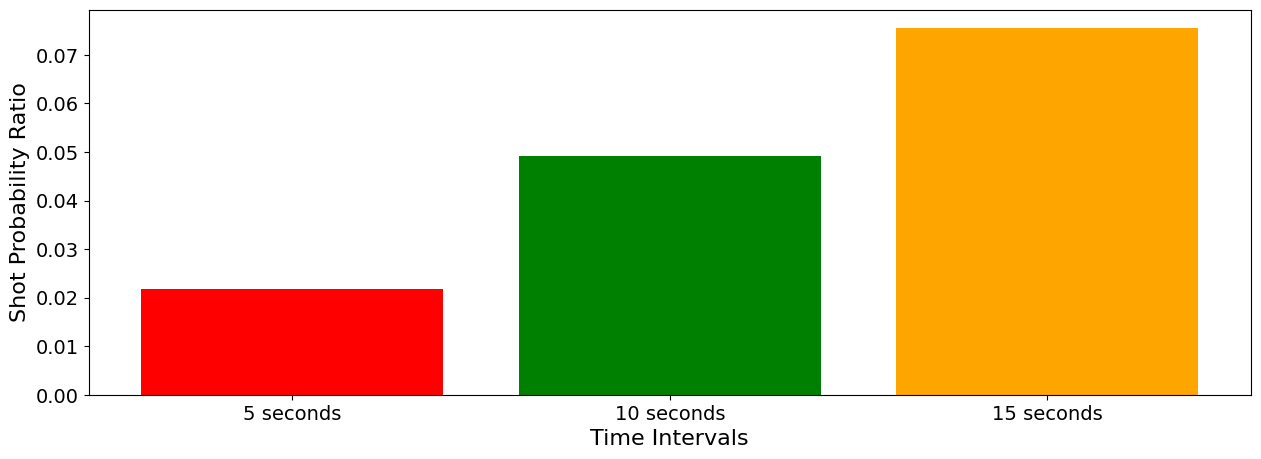

In [12]:
# Create bar plot 
plt.figure(figsize=(15, 5))
time_intervals = ['5 seconds', '10 seconds', '15 seconds']
ratios = [ratio_5sec, ratio_10sec, ratio_15sec]
plt.bar(time_intervals, ratios, color=['red', 'green', 'orange'])

plt.xticks(fontsize=14)
plt.yticks(fontsize=14)

plt.xlabel('Time Intervals', fontsize=16)
plt.ylabel('Shot Probability Ratio', fontsize=16)
plt.show()



In [13]:
print(recovered_10sec[recovered_10sec['shotwithin10sec']==1].shape[0])
print(recovered_10sec[recovered_10sec['shotwithin10sec']==0].shape[0])

1277
24695


Additionaly average time of possession chain defined as per soccermatics course is 9.3 so close to 10.

# Functions that create features for model

In [14]:
def split_position(df, position_col):
    """
    Splits a column containing position data into separate start and end positions. (helper function)
    
    This function takes a column that contains a list of position dictionaries (with 'x' and 'y' coordinates),
    and splits it into four separate columns: 'x_start', 'y_start', 'x_end', and 'y_end'.
    It drops the original column once the split is done.

    Parameters:
    df (pd.DataFrame): The input DataFrame containing position data.
    position_col (str): The name of the column that contains the position information 
                        (a list of dictionaries with 'x' and 'y' keys).

    Returns:
    pd.DataFrame: The modified DataFrame with new columns 'x_start', 'y_start', 'x_end', and 'y_end'
                  representing the start and end coordinates of the event. The original position 
                  column is dropped.
    """
    df['x_start'] = df[position_col].apply(lambda pos: pos[0]['x'] if isinstance(pos, list) and len(pos) > 0 and 'x' in pos[0] else None)
    df['y_start'] = df[position_col].apply(lambda pos: pos[0]['y'] if isinstance(pos, list) and len(pos) > 0 and 'y' in pos[0] else None)
    df['x_end'] = df[position_col].apply(lambda pos: pos[-1]['x'] if isinstance(pos, list) and len(pos) > 0 and 'x' in pos[-1] else None)
    df['y_end'] = df[position_col].apply(lambda pos: pos[-1]['y'] if isinstance(pos, list) and len(pos) > 0 and 'y' in pos[-1] else None)
    
    df = df.drop(columns=[position_col])  # Drop the original position column
    
    return df




def calculate_distance_to_goal(df):
    """
    Calculates the Euclidean distance from the start position of an event to the goal.

    Parameters:
    df (pd.DataFrame): The input DataFrame containing event data. It must include 'x_start' and 'y_start'
                       columns, which represent the starting coordinates of each event.

    Returns:
    pd.DataFrame: The modified DataFrame with an additional 'distance_to_goal' column, which contains
                  the calculated distance from the starting position to the goal.
    """
    # Calculate the distance to the goal for each event
    df['distance_to_goal'] = np.sqrt((100 - df['x_start'])**2 + (50 - df['y_start'])**2)
    
    return df





def process_passes(df):
    """
    Processes passes after a ball recovery event and assigns attributes such as 
    forward pass, backward pass, and pass distance.

    This function finds the first pass made by the same player who performed a recovery 
    and calculates whether the pass was forward or backward, along with the distance 
    of the pass. It only considers passes made in the same match period as the recovery.

    Parameters:
    df (pd.DataFrame): The input DataFrame containing event data, including recovery events,
                       player IDs, match periods, and coordinates (x_start, y_start, x_end, y_end).
                       It assumes that the DataFrame already has columns 'recovery', 'x_start', 
                       'y_start', 'x_end', and 'y_end'.

    Returns:
    pd.DataFrame: The modified DataFrame with three additional columns:
                  - 'forward_pass': 1 if the pass after recovery was forward, otherwise 0.
                  - 'backward_pass': 1 if the pass after recovery was backward, otherwise 0.
                  - 'pass_distance': The Euclidean distance of the pass in meters.
    """
    
    df['forward_pass'] = 0
    df['backward_pass'] = 0
    df['pass_distance'] = np.nan    
    goal_x, goal_y = 100, 50
    
    # Iterate through the dataframe
    for i in range(len(df)):
        if df.loc[i, 'recovery'] == 1:
            recovery_player_id = df.loc[i, 'playerId']  
            recovery_match_period = df.loc[i, 'matchPeriod']
            
            # Find the next row that contains a 'Pass' by the same player
            for j in range(i + 1, len(df)):
                if 'Pass' in df.loc[j, 'eventName'] and df.loc[j, 'playerId'] == recovery_player_id:
                    pass_match_period = df.loc[j, 'matchPeriod'] 
                    
                    if pass_match_period != recovery_match_period:
                        df.loc[i, 'pass_distance'] = 0
                        break

                    # Get the coordinates
                    x_start, y_start = df.loc[j, 'x_start'], df.loc[j, 'y_start']
                    x_end, y_end = df.loc[j, 'x_end'], df.loc[j, 'y_end']

                    x_diff = x_end - x_start
                    if x_diff > 0:
                        df.loc[i, 'forward_pass'] = 1
                    else:
                        df.loc[i, 'backward_pass'] = 1
                    
                    pass_distance = np.sqrt((x_end - x_start) ** 2 + (y_end - y_start) ** 2)
                    df.loc[i, 'pass_distance'] = pass_distance
                    
                    break  # Stop after processing the first pass after recovery by the same player
    
    # Fill any missing values in the new columns with 0
    df['forward_pass'].fillna(0, inplace=True)
    df['backward_pass'].fillna(0, inplace=True)
    df['pass_distance'].fillna(0, inplace=True)
    
    return df





def add_match_result_column(df):
    """
    Adds a 'result' column to the DataFrame to track the score progression of each match.
    
    Args:
    - df: DataFrame containing event data.
    
    Returns:
    - DataFrame with the 'result' column added.
    """

    df['result'] = 0

    # Iterate through each match_id
    for match_id in df['matchId'].unique():
        # Filter the DataFrame for the current match
        match_df = df[df['matchId'] == match_id]
        
        # Initialize score tracking for both teams
        team_goals = {}
        current_result = 0 
        
        team_a = match_df.iloc[0]['teamId']  
        team_b = match_df[match_df['teamId'] != team_a].iloc[0]['teamId'] 

        team_goals[team_a] = 0
        team_goals[team_b] = 0

        for idx, row in match_df.iterrows():
            team_id = row['teamId']
            
            # Check if both 'Goal' and 'accurate' are in the 'tagNames' column
            if 'Goal' in row['tagNames'] and 'accurate' in row['tagNames']:
                # Increment goal count for the scoring team
                team_goals[team_id] += 1

            # Calculate the current result based on goals scored by both teams
            current_result = team_goals[team_a] - team_goals[team_b]

            # Assign the current result to the 'result' column
            if team_id == team_a:
                df.at[idx, 'result'] = current_result 
            else:
                df.at[idx, 'result'] = -current_result  

    return df



def add_central_area_column(df):
    """
    Function to add a 'central_area' column based on the 'y' coordinate.
    If the 'y' coordinate is between 18 and 81, it assigns 1 (central area), otherwise 0.
    """
    df['central_area'] = df['y_start'].apply(lambda y: 1 if 18 <= y <= 81 else 0)
    return df



### Apply the functions to 10 seconds dataframe

In [15]:
df_final = df_10sec.copy()

df_final = split_position(df_final, 'positions')
df_final = calculate_distance_to_goal(df_final)
df_final = process_passes(df_final)
df_final = add_match_result_column(df_final)
df_final = add_central_area_column(df_final)



/var/folders/n3/4qctfjhd43j9h6fypc3p1h480000gn/T/ipykernel_48903/1254871625.py:110: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df['forward_pass'].fillna(0, inplace=True)
/var/folders/n3/4qctfjhd43j9h6fypc3p1h480000gn/T/ipykernel_48903/1254871625.py:111: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always

In [16]:
df_recovery = df_final[df_final['recovery'] == 1]

In [17]:
#Na values in df_recovery
df_recovery.isna().sum()

eventId             0
subEventName        0
playerId            0
matchId             0
eventName           0
teamId              0
matchPeriod         0
eventSec            0
subEventId          0
id                  0
tagNames            0
shotwithin10sec     0
recovery            0
x_start             0
y_start             0
x_end               0
y_end               0
distance_to_goal    0
forward_pass        0
backward_pass       0
pass_distance       0
result              0
central_area        0
dtype: int64

# Analysis of additional variables that could be useful

### Considering tags

In [18]:
# get unique values of df_recovery['tagNames'].
unique_tags = df_recovery['tagNames'].explode().unique()
unique_tags

array(['interception', 'won', 'accurate', 'missed ball', nan, 'neutral',
       'take_on_r', 'counter_attack', 'anticipated', 'sliding_tackle',
       'take_on_l', 'anticipation', 'free_space_l', 'free_space_r',
       'not accurate', 'Feint', 'dangerous_ball_lost', 'opportunity',
       'own_goal', 'keyPass', 'assist'], dtype=object)

In [19]:
#get count of each tag
tag_counts = df_recovery['tagNames'].explode().value_counts()
print(tag_counts)

tagNames
accurate               20401
won                    15882
interception            5028
neutral                 3069
anticipated             1205
counter_attack          1079
take_on_r                974
take_on_l                935
free_space_l             834
free_space_r             830
sliding_tackle           647
not accurate             535
missed ball              177
anticipation             142
own_goal                  20
Feint                     10
dangerous_ball_lost        4
opportunity                2
keyPass                    1
assist                     1
Name: count, dtype: int64


### As there is small amount of anticipations tackles that are actually defined similar to interceptions decided to merge them and distinguish from sliding_tackle and 'other' category 

In [20]:
def one_hot_encode_tags(df):
    """
    Function to create one-hot encoded columns for specific tag groups:
    - 'anticipation_interception' for both anticipation and interception.
    - 'sliding_tackle' for sliding tackles.
    
    If both columns are 0, it indicates the 'other' category implicitly.

    Parameters:
    df (pd.DataFrame): DataFrame containing a 'tags' column with lists of tags.

    Returns:
    pd.DataFrame: Updated DataFrame with one-hot encoded columns for the groups.
    """
    
    anticipation_interception_tags = ['anticipation', 'interception']
    sliding_tackle_tag = 'sliding_tackle'
    
    df.loc[:, 'anticipation_interception'] = df['tagNames'].apply(
        lambda tag_list: 1 if any(tag in tag_list for tag in anticipation_interception_tags) else 0
    )
    df.loc[:, 'sliding_tackle'] = df['tagNames'].apply(
        lambda tag_list: 1 if sliding_tackle_tag in tag_list else 0
    )
    
    return df


In [21]:
df_recovery = one_hot_encode_tags(df_recovery)

/var/folders/n3/4qctfjhd43j9h6fypc3p1h480000gn/T/ipykernel_48903/2474692118.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[:, 'anticipation_interception'] = df['tagNames'].apply(
/var/folders/n3/4qctfjhd43j9h6fypc3p1h480000gn/T/ipykernel_48903/2474692118.py:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[:, 'sliding_tackle'] = df['tagNames'].apply(


### Convert time to minutes and adjust for entire match not just half

In [22]:
def add_minute_of_match(df):
    """
    Function to add a 'minute_of_match' column to the DataFrame based on match period (1H or 2H)
    and event seconds.

    For the second half (2H), the function adjusts the time by adding 45 minutes (45 * 60 seconds) 
    to the 'eventSec', then divides by 60 to get the minute of the match.

    Parameters:
    df (pd.DataFrame): DataFrame containing 'matchPeriod' and 'eventSec' columns.

    Returns:
    pd.DataFrame: Updated DataFrame with 'minute_of_match' column.
    """
    
    # Create 'minute_of_match' column
    df['minute_of_match'] = df.apply(
        lambda row: (45 * 60 + row['eventSec']) / 60 if row['matchPeriod'] == '2H' else row['eventSec'] / 60,
        axis=1
    )
    
    return df


In [23]:
df_recovery = add_minute_of_match(df_recovery)

/var/folders/n3/4qctfjhd43j9h6fypc3p1h480000gn/T/ipykernel_48903/2284569156.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['minute_of_match'] = df.apply(


# Explore deeper final variables

### distance_to_goal

In [24]:
df_recovery.distance_to_goal.describe()

count    25972.000000
mean        71.316835
std         18.446772
min          3.000000
25%         58.549125
50%         73.164199
75%         86.271374
max        110.462663
Name: distance_to_goal, dtype: float64

In [25]:
#look for row where distance to goal is maximum
max_passes = df_recovery[df_recovery['distance_to_goal']==df_recovery.distance_to_goal.max()]
min_passes = df_recovery[df_recovery['distance_to_goal']==df_recovery.distance_to_goal.min()]

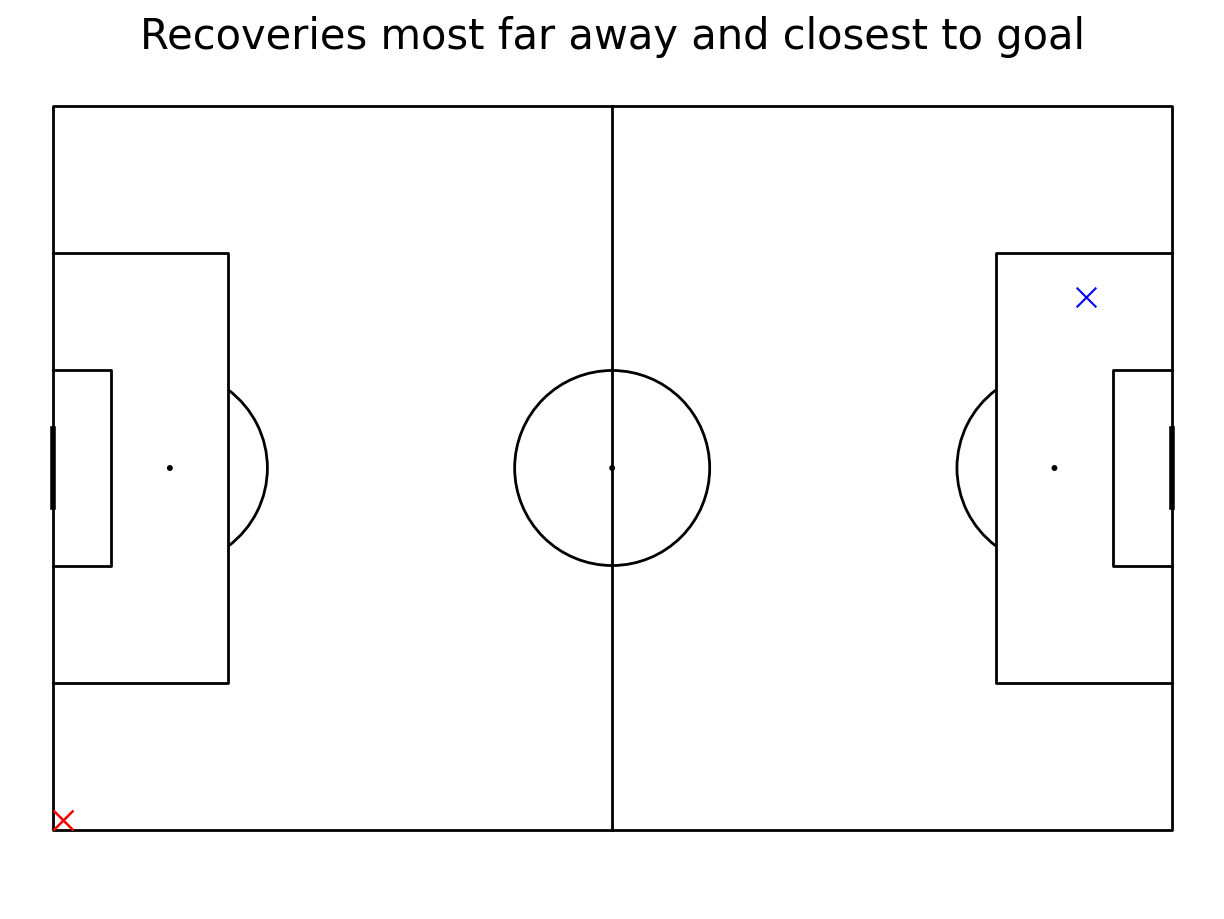

In [26]:
from mplsoccer import Pitch
import matplotlib.pyplot as plt


pitch = Pitch(line_color='black',pitch_type='custom', pitch_length=105, pitch_width=68, line_zorder = 2)
fig, ax = pitch.grid(grid_height=0.9, title_height=0.06, axis=False,
                     endnote_height=0.04, title_space=0, endnote_space=0)

#passes
pitch.scatter(max_passes.x_start, max_passes.y_start, marker = 'x', color = "red", ax=ax['pitch'], zorder =  3, s= 200)
pitch.scatter(min_passes.x_start, min_passes.y_start, marker = 'x', color = "blue", ax=ax['pitch'], zorder =  3, s= 200)

ax['title'].text(0.5, 0.5, 'Recoveries most far away and closest to goal', ha='center', va='center', fontsize=30)
plt.show()              

### pass_distance

In [27]:
df_recovery.pass_distance.describe()

count    25972.000000
mean        22.907502
std         16.528557
min          0.000000
25%         11.401754
50%         19.313208
75%         30.413813
max        133.660016
Name: pass_distance, dtype: float64

In [28]:
#look for row where distance to goal is maximum
max_passes_distance = df_recovery[df_recovery['pass_distance']==df_recovery.pass_distance.max()]
min_passes_distance = df_recovery[df_recovery['pass_distance']==df_recovery.pass_distance.min()]

In [29]:
max_passes_distance[['x_start', 'y_start', 'x_end', 'y_end', 'pass_distance']]

,x_start,y_start,x_end,y_end,pass_distance
129046,64,23,51,9,133.660016


### central_area

In [30]:
df_recovery['central_area'].value_counts()

central_area
1    17238
0     8734
Name: count, dtype: int64

### minute_of_match

In [31]:
df_recovery['minute_of_match'].describe()

count    25972.000000
mean        46.281799
std         26.955732
min          0.045804
25%         23.290334
50%         46.031343
75%         69.009697
max        102.106915
Name: minute_of_match, dtype: float64

# Correlation Matrix

In [32]:
print(df_recovery[['distance_to_goal', 'minute_of_match', 'pass_distance','anticipation_interception','result', 'central_area']].corr())


                           distance_to_goal  minute_of_match  pass_distance  \
distance_to_goal                   1.000000         0.035388       0.089917   
minute_of_match                    0.035388         1.000000      -0.039730   
pass_distance                      0.089917        -0.039730       1.000000   
anticipation_interception          0.152464         0.003522       0.045105   
result                             0.019326         0.004023      -0.016341   
central_area                      -0.090522         0.026345       0.043065   

                           anticipation_interception    result  central_area  
distance_to_goal                            0.152464  0.019326     -0.090522  
minute_of_match                             0.003522  0.004023      0.026345  
pass_distance                               0.045105 -0.016341      0.043065  
anticipation_interception                   1.000000 -0.001750      0.078058  
result                                     -0.00175

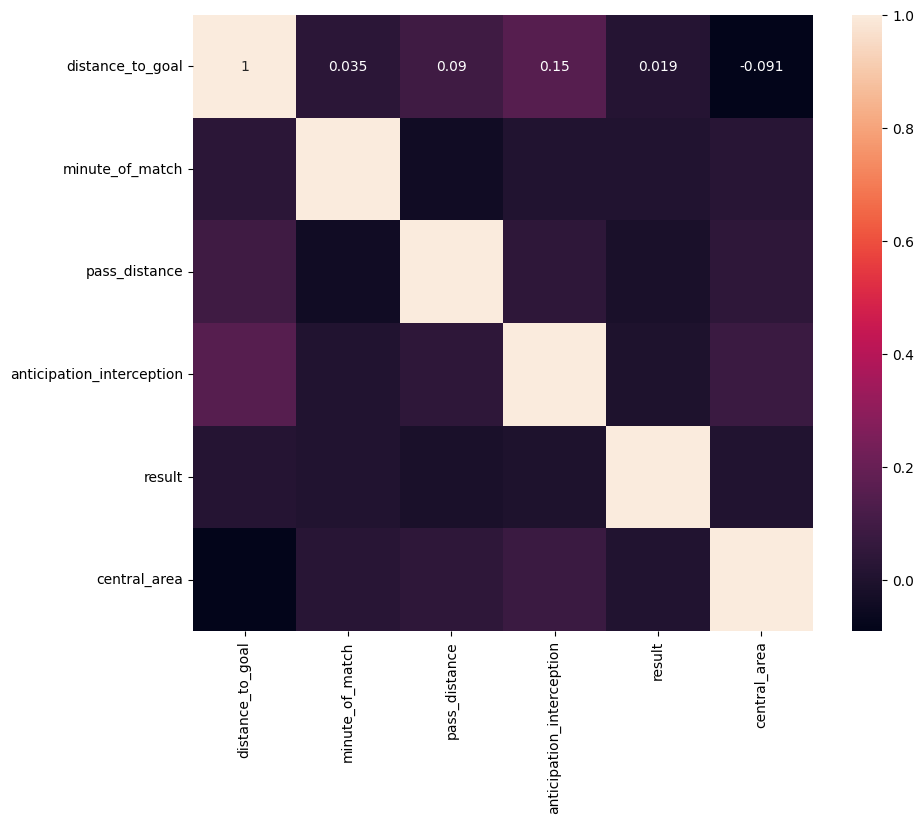

In [33]:
# how to see correlation between variables
df_recovery[['distance_to_goal', 'minute_of_match', 'pass_distance','anticipation_interception','result', 'central_area']].corr()

#plot it using correlation matrix
plt.figure(figsize=(10, 8))
sns.heatmap(df_recovery[['distance_to_goal', 'minute_of_match', 'pass_distance','anticipation_interception','result', 'central_area']].corr(), annot=True)
plt.show()

In [34]:
#show biggest correlation
df_recovery[['distance_to_goal', 'minute_of_match', 'pass_distance','anticipation_interception','result', 'central_area']].corr().unstack().sort_values(ascending=False).drop_duplicates()

distance_to_goal           distance_to_goal             1.000000
                           anticipation_interception    0.152464
pass_distance              distance_to_goal             0.089917
anticipation_interception  central_area                 0.078058
                           pass_distance                0.045105
pass_distance              central_area                 0.043065
minute_of_match            distance_to_goal             0.035388
                           central_area                 0.026345
distance_to_goal           result                       0.019326
central_area               result                       0.005835
minute_of_match            result                       0.004023
anticipation_interception  minute_of_match              0.003522
                           result                      -0.001750
result                     pass_distance               -0.016341
pass_distance              minute_of_match             -0.039730
central_area             

In [35]:
df_recovery[['distance_to_goal', 'minute_of_match', 'pass_distance', 'anticipation_interception','result','central_area']].describe()

,distance_to_goal,minute_of_match,pass_distance,anticipation_interception,result,central_area
count,25972.000000,25972.000000,25972.000000,25972.000000,25972.000000,25972.000000
mean,71.316835,46.281799,22.907502,0.198791,0.021908,0.663715
std,18.446772,26.955732,16.528557,0.399098,1.164042,0.472447
min,3.000000,0.045804,0.000000,0.000000,-6.000000,0.000000
25%,58.549125,23.290334,11.401754,0.000000,0.000000,0.000000
50%,73.164199,46.031343,19.313208,0.000000,0.000000,1.000000
75%,86.271374,69.009697,30.413813,0.000000,1.000000,1.000000
max,110.462663,102.106915,133.660016,1.000000,6.000000,1.000000


### As features look correct, now we can build the model

# Building Model

## First model

### Trained on whole dataset

In [36]:
df_recovery.columns

Index(['eventId', 'subEventName', 'playerId', 'matchId', 'eventName', 'teamId',
       'matchPeriod', 'eventSec', 'subEventId', 'id', 'tagNames',
       'shotwithin10sec', 'recovery', 'x_start', 'y_start', 'x_end', 'y_end',
       'distance_to_goal', 'forward_pass', 'backward_pass', 'pass_distance',
       'result', 'central_area', 'anticipation_interception', 'sliding_tackle',
       'minute_of_match'],
      dtype='object')

In [37]:
X = df_recovery[['distance_to_goal', 'forward_pass', 'minute_of_match', 'pass_distance','anticipation_interception', 'sliding_tackle','result', 'central_area']]
X = sm.add_constant(X)


In [38]:
# Calculate VIF for each feature
vif_data = pd.DataFrame()
vif_data["Feature"] = X.columns
vif_data["VIF"] = [variance_inflation_factor(X.values, i) for i in range(len(X.columns))]

print(vif_data)


                     Feature        VIF
0                      const  23.015127
1           distance_to_goal   1.058178
2               forward_pass   1.057006
3            minute_of_match   1.004250
4              pass_distance   1.053162
5  anticipation_interception   1.040932
6             sliding_tackle   1.006565
7                     result   1.000942
8               central_area   1.022990


Optimization terminated successfully.
         Current function value: 0.180374
         Iterations 8
                           Logit Regression Results                           
Dep. Variable:        shotwithin10sec   No. Observations:                25972
Model:                          Logit   Df Residuals:                    25963
Method:                           MLE   Df Model:                            8
Date:                Sun, 20 Oct 2024   Pseudo R-squ.:                 0.08000
Time:                        21:01:01   Log-Likelihood:                -4684.7
converged:                       True   LL-Null:                       -5092.0
Covariance Type:            nonrobust   LLR p-value:                1.375e-170
                                coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------------------
const                        -0.5430      0.127     -4.264      0.000      -0.

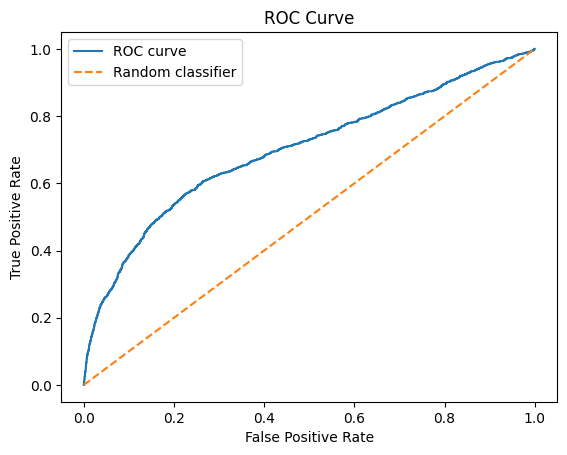

In [39]:
# Target: Whether a shot occurred within 10 seconds
y = df_recovery['shotwithin10sec']

logit_model = sm.Logit(y, X)
result = logit_model.fit()

# Print the summary, which includes coefficients, p-values, and more
print(result.summary())

# Predict on the test set using the fitted model
y_pred = result.predict(X)
y_pred_binary = np.where(y_pred > 0.05, 1, 0)  # Convert probabilities to binary 0 or 1

# Evaluate the model
accuracy = accuracy_score(y, y_pred_binary)
roc_auc = roc_auc_score(y, y_pred)

print(f"Accuracy: {accuracy}")
print(f"AUC-ROC: {roc_auc}")

# Plot the ROC curve
fpr, tpr, thresholds = metrics.roc_curve(y, y_pred)
plt.plot(fpr, tpr, label='ROC curve')
plt.plot([0, 1], [0, 1], linestyle='--', label='Random classifier')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend()
plt.show()


## Second model (only siginficant variables from first model)

### Trained on entire dataset

In [40]:
# Features: Recovery coordinates, pass length, pass speed, xT value
X_1 = df_recovery[['distance_to_goal', 'minute_of_match', 'pass_distance', 'anticipation_interception','result','central_area']]

# add constant to the features for the intercept
X_1 = sm.add_constant(X_1)

# Add a constant to the features for the intercept
# Target: Whether a shot occurred within 10 seconds
y = df_recovery['shotwithin10sec']

logit_model_1 = sm.Logit(y, X_1)
result_1 = logit_model_1.fit()

# Print the summary, which includes coefficients, p-values, and more
print(result_1.summary())

# Predict on the test set using the fitted model
y_pred_1 = result_1.predict(X_1)
y_pred_binary_1 = np.where(y_pred_1 > 0.05, 1, 0)  # Convert probabilities to binary 0 or 1

# Evaluate the model
accuracy_1 = accuracy_score(y, y_pred_binary_1)
roc_auc_1 = roc_auc_score(y, y_pred_1)

print(f"Accuracy: {accuracy_1}")
print(f"AUC-ROC: {roc_auc_1}")


Optimization terminated successfully.
         Current function value: 0.180411
         Iterations 8
                           Logit Regression Results                           
Dep. Variable:        shotwithin10sec   No. Observations:                25972
Model:                          Logit   Df Residuals:                    25965
Method:                           MLE   Df Model:                            6
Date:                Sun, 20 Oct 2024   Pseudo R-squ.:                 0.07982
Time:                        21:01:01   Log-Likelihood:                -4685.6
converged:                       True   LL-Null:                       -5092.0
Covariance Type:            nonrobust   LLR p-value:                2.573e-172
                                coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------------------
const                        -0.5686      0.126     -4.517      0.000      -0.

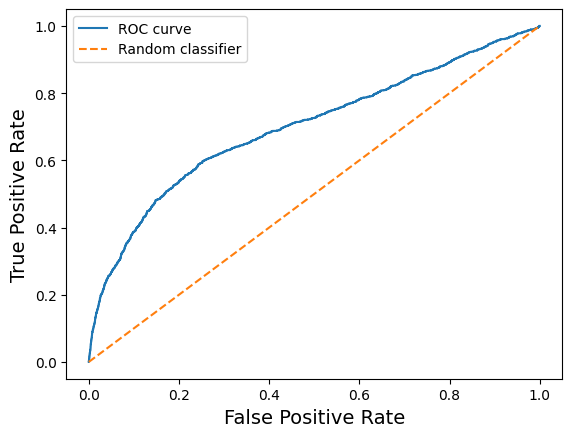

In [41]:
# Plot the ROC curve
fpr, tpr, thresholds = metrics.roc_curve(y, y_pred_1)
plt.plot(fpr, tpr, label='ROC curve')
plt.plot([0, 1], [0, 1], linestyle='--', label='Random classifier')
plt.xlabel('False Positive Rate', fontsize=14)
plt.ylabel('True Positive Rate', fontsize=14)
plt.legend()
plt.show()

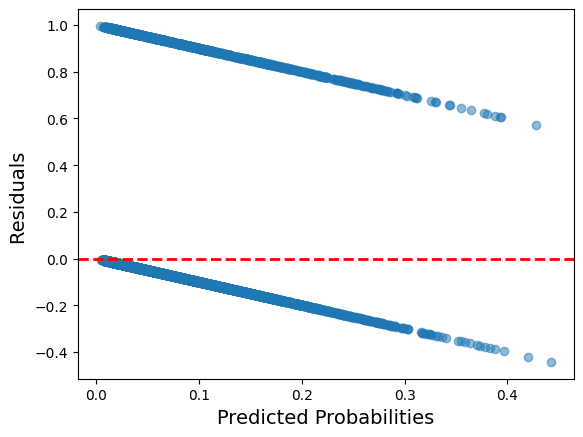

In [42]:
# Calculate residuals (Actual - Predicted Probabilities)
residuals = y - y_pred_1

plt.scatter(y_pred_1, residuals, alpha=0.5)
plt.axhline(0, color='red', linestyle='--', linewidth=2)
plt.xlabel('Predicted Probabilities', fontsize=14)
plt.ylabel('Residuals ', fontsize=14)
plt.show()


In [43]:
# Calculate VIF for each feature
vif_data = pd.DataFrame()
vif_data["Feature"] = X_1.columns
vif_data["VIF"] = [variance_inflation_factor(X_1.values, i) for i in range(len(X_1.columns))]

print(vif_data)


                     Feature        VIF
0                      const  22.517455
1           distance_to_goal   1.045560
2            minute_of_match   1.004163
3              pass_distance   1.013953
4  anticipation_interception   1.033599
5                     result   1.000807
6               central_area   1.020695


In [44]:
# Create a DataFrame to compare actual and predicted values
comparison_df = pd.DataFrame({
    'Actual': y,
    'Predicted_Probability': y_pred_1,
    'Predicted_Binary': y_pred_binary_1
})

comparison_df['Predicted_Binary'].value_counts()   
comparison_df['Correct'] = comparison_df['Actual'] == comparison_df['Predicted_Binary']
print('Shot class')
print(comparison_df[comparison_df['Actual'] == 1]['Correct'].value_counts(normalize=True))
print('No shot class')
print(comparison_df[comparison_df['Actual'] == 0]['Correct'].value_counts(normalize=True))



Shot class
Correct
True     0.624902
False    0.375098
Name: proportion, dtype: float64
No shot class
Correct
True     0.700142
False    0.299858
Name: proportion, dtype: float64


## Under result_1 final model is stored

In [45]:
result_1.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:        shotwithin10sec   No. Observations:                25972
Model:                          Logit   Df Residuals:                    25965
Method:                           MLE   Df Model:                            6
Date:                Sun, 20 Oct 2024   Pseudo R-squ.:                 0.07982
Time:                        21:01:02   Log-Likelihood:                -4685.6
converged:                       True   LL-Null:                       -5092.0
Covariance Type:            nonrobust   LLR p-value:                2.573e-172
=============================================================================================
                                coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------------------
const                        -0.5686      0.126     -4.517      0.000      -0.815      -0.322
distance_to_goal             -0.0407      0.002    -26.759      0.000      -0.044      -0.038
minute_of_match               0.0036      0.001      3.305      0.001       0.001       0.006
pass_distance                -0.0053      0.002     -2.763      0.006      -0.009      -0.002
anticipation_interception     0.3687      0.072      5.153      0.000       0.228       0.509
result                        0.0818      0.024      3.361      0.001       0.034       0.129
central_area                  0.1533      0.067      2.303      0.021       0.023       0.284
=============================================================================================
"""

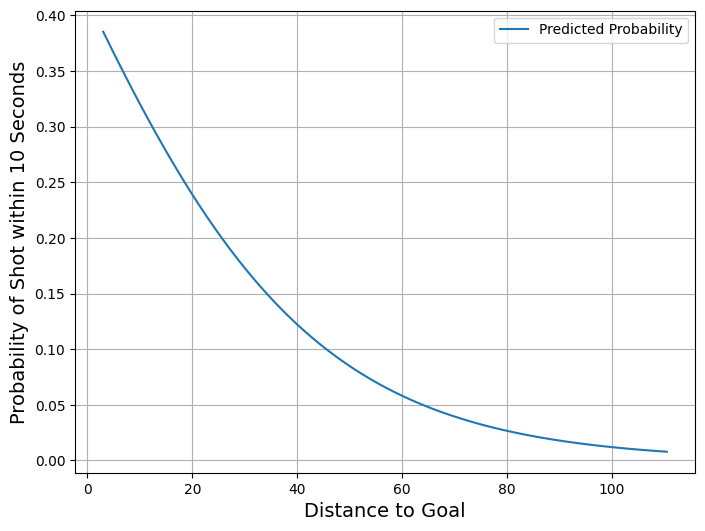

In [46]:
# Plot probability curve for 'distance_to_goal'
distance_values = np.linspace(X_1['distance_to_goal'].min(), X_1['distance_to_goal'].max(), 100)

X_plot = X_1.mean().to_frame().T  # Use mean values for all other features
X_plot = X_plot.loc[np.repeat(X_plot.index, 100)]  
X_plot['distance_to_goal'] = distance_values

probs = result_1.predict(X_plot)

plt.figure(figsize=(8, 6))
plt.plot(distance_values, probs, label='Predicted Probability')
plt.xlabel('Distance to Goal', fontsize=14)
plt.ylabel('Probability of Shot within 10 Seconds', fontsize=14)
plt.legend()
plt.grid(True)
plt.show()

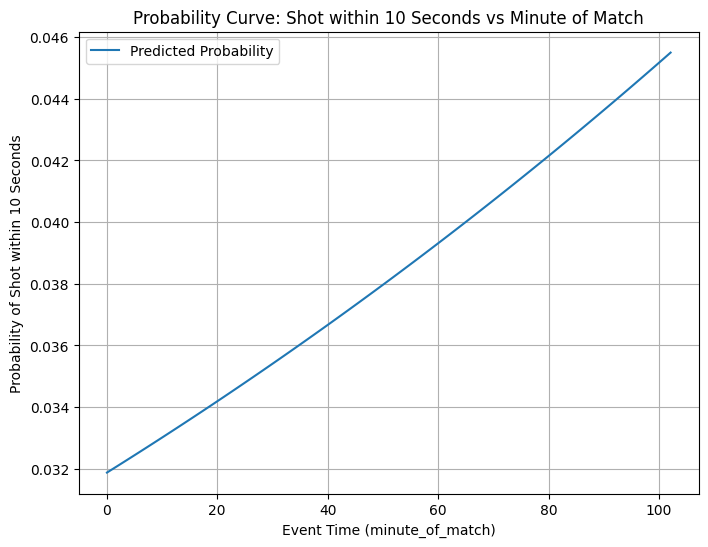

In [47]:
# Plot probability curve for 'minute of match'
time_values = np.linspace(X_1['minute_of_match'].min(), X_1['minute_of_match'].max(), 102)

X_plot = X_1.mean().to_frame().T  # Use mean values for all other features
X_plot = X_plot.loc[np.repeat(X_plot.index, 102)] 
X_plot['minute_of_match'] = time_values

probs = result_1.predict(X_plot)

plt.figure(figsize=(8, 6))
plt.plot(time_values, probs, label='Predicted Probability')
plt.xlabel('Event Time (minute_of_match)')
plt.ylabel('Probability of Shot within 10 Seconds')
plt.title('Probability Curve: Shot within 10 Seconds vs Minute of Match')
plt.legend()
plt.grid(True)
plt.show()

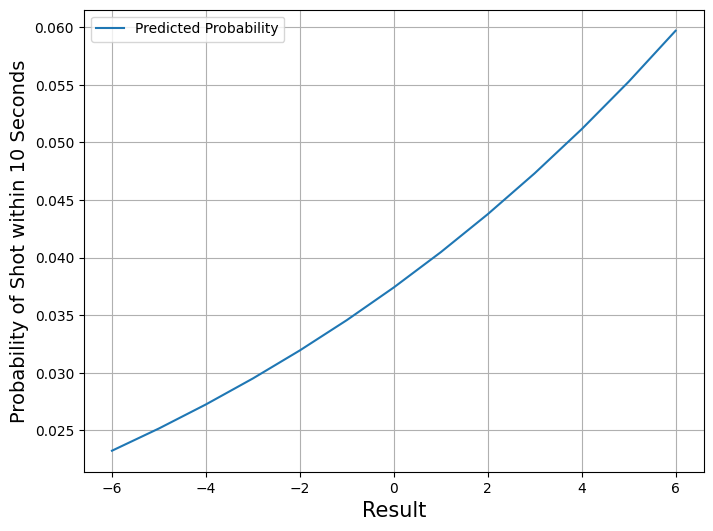

In [48]:
# Plot probability curve for 'result'

result_values = np.linspace(X_1['result'].min(), X_1['result'].max(), 13)

X_plot = X_1.mean().to_frame().T  # Use mean values for all other features
X_plot = X_plot.loc[np.repeat(X_plot.index, 13)]  
X_plot['result'] = result_values

probs = result_1.predict(X_plot)

plt.figure(figsize=(8, 6))
plt.plot(result_values, probs, label='Predicted Probability')
plt.xlabel('Result', fontsize=15)  # Adjust label to represent 'result'
plt.ylabel('Probability of Shot within 10 Seconds', fontsize=14)
plt.legend()
plt.grid(True)
plt.show()

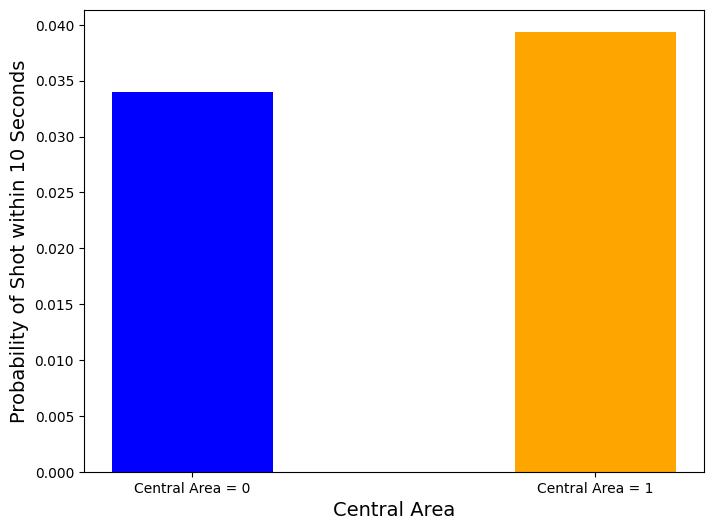

In [49]:
central_area_values = np.linspace(X_1['central_area'].min(), X_1['central_area'].max(), 2)

X_plot = X_1.mean().to_frame().T
X_plot = X_plot.loc[np.repeat(X_plot.index, 2)] 
X_plot['central_area'] = central_area_values

probs = result_1.predict(X_plot)

plt.figure(figsize=(8, 6))
plt.bar(central_area_values, probs, width=0.4, color=['blue', 'orange'], tick_label=['Central Area = 0', 'Central Area = 1'])

plt.xlabel('Central Area', fontsize=14)
plt.ylabel('Probability of Shot within 10 Seconds', fontsize=14)
plt.show()


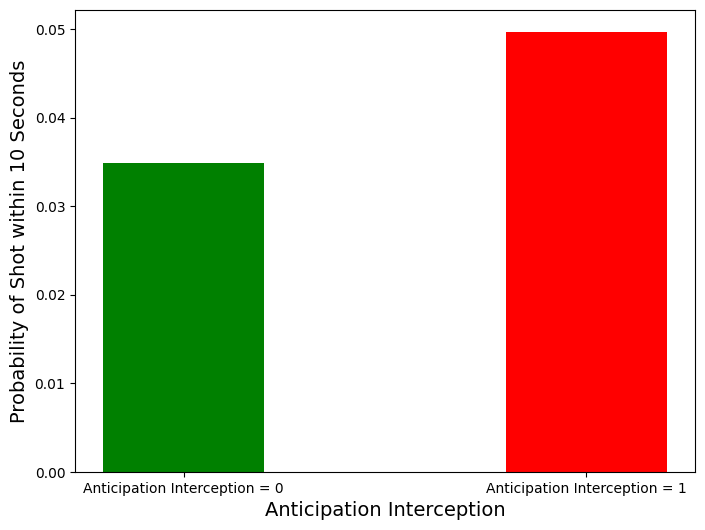

In [50]:
anticipation_interception_values = np.linspace(X_1['anticipation_interception'].min(), X_1['anticipation_interception'].max(), 2)

X_plot = X_1.mean().to_frame().T
X_plot = X_plot.loc[np.repeat(X_plot.index, 2)] 
X_plot['anticipation_interception'] = anticipation_interception_values

probs = result_1.predict(X_plot)

plt.figure(figsize=(8, 6))
plt.bar(anticipation_interception_values, probs, width=0.4, color=['green', 'red'], tick_label=['Anticipation Interception = 0', 'Anticipation Interception = 1'])

plt.xlabel('Anticipation Interception', fontsize=14)
plt.ylabel('Probability of Shot within 10 Seconds', fontsize=14)
plt.show()


# Testing Model on other leagues

### Firstly preprocessing the data for other leagues in order to input into the model

In [56]:
def process_data(file_name, tags):
    """
    Function to process event data and return the recovery DataFrame.
    
    Parameters:
    file_name (str): The path to the JSON file containing event data.
    tags (list of tuples): List containing tag ID and tag name pairs.
    
    Returns:
    pd.DataFrame: Processed DataFrame with recovery events.
    """

    with open(file_name, 'r') as f:
        data = json.load(f)
    df = pd.DataFrame(data)
    
    # Step 2: Preprocess the data
    df = map_and_drop_tags(df, tags)  # Map tag IDs to tag names
    df = drop_invalid_players_and_reset_index(df)  # Drop invalid player IDs
    df = add_shot_within_X_sec(df, 10)  # Add shot within 10 seconds feature
    df = assign_recovery_with_team_and_pass_check(df)  # Assign recovery with team and pass check
    df = split_position(df, 'positions')  # Split positions
    df = calculate_distance_to_goal(df)  # Calculate distance to goal
    df = process_passes(df)  # Process passes
    df = add_match_result_column(df)  # Add match result column
    df = add_central_area_column(df)
    df = add_minute_of_match(df)


    # Step 3: Filter for recovery events
    df_recovery = df[df['recovery'] == 1].copy()  # Use .copy() to avoid SettingWithCopyWarning
    df_recovery = one_hot_encode_tags(df_recovery)  # One-hot encoding step
    df_recovery.loc[:, 'eventSec'] = df_recovery['eventSec'] / 60

    return df_recovery

### Preprocessing data for player data

In [57]:
def process_player_data(directory, players_file, min_minutes=0.6*3420):
    """
    Loads and processes player data, including filtering players based on minutes played 
    and calculating their age.

    This function loads player data from a given file and minutes played data from multiple 
    files in a specified directory. It then sums the minutes played for each player, filters 
    players based on a specified minimum minutes threshold, and calculates each player's 
    age as of a reference date (July 1, 2018).

    Parameters:
    directory (str): The path to the directory containing minutes played data files in JSON format.
    players_file (str): The path to the file containing player data in JSON format.
    min_minutes (float): The minimum minutes threshold for filtering players. The default 
                         is 0.6 * 3420, representing 60% of a full season (3420 minutes).

    Returns:
    pd.DataFrame: A DataFrame containing player data, including their calculated age 
                  and total minutes played. Only players who played more than the specified 
                  minimum minutes are included.

    """
    
    # Load players data
    with open(players_file, 'r') as f:
        df_players = pd.DataFrame(json.load(f))
    
    # List to store the DataFrames for minutes played
    dfs = []

    # Iterate over each file in the directory and load minutes data
    for file in os.listdir(directory):
        if file.endswith(".json") and file.startswith("minutes"):
            with open(os.path.join(directory, file), 'r') as f:
                data = json.load(f)
                dfs.append(pd.DataFrame(data))

    df_minutes = pd.concat(dfs, ignore_index=True)

    df_minutes = df_minutes.groupby('playerId')['minutesPlayed'].sum().reset_index()
    df_players = df_players.merge(df_minutes, left_on='wyId', right_on='playerId', how='left')
    df_players = df_players[df_players['minutesPlayed'] > min_minutes]

    df_players['birthDate'] = pd.to_datetime(df_players['birthDate']) 
    reference_date = pd.to_datetime('2018-07-01') 

    df_players['age'] = (reference_date - df_players['birthDate']).dt.days // 365  # Age in years

    return df_players


### Functions to predict top players using model in other leagues

In [58]:
def predict_top_players(df_recovery, result):
    """
    Function to predict probabilities using the model and return the top players by total contribution.
    
    Parameters:
    df_recovery (pd.DataFrame): DataFrame containing recovery events.
    result (statsmodels LogitResults): Trained logistic regression model result.
    
    Returns:
    pd.DataFrame: DataFrame containing player contributions sorted by total contribution.
    """
    
    feature_columns = result.model.exog_names  # Extract feature names from the model
    
    # Add 'const' column if required by the model
    if 'const' in result.model.exog_names and 'const' not in df_recovery.columns:
        df_recovery.loc[:, 'const'] = 1  
    
    feature_columns = [col for col in feature_columns if col in df_recovery.columns]
    X = df_recovery[feature_columns]
    
    df_recovery.loc[:, 'predicted_prob'] = result.predict(X)  # Use .loc for assignment
    player_contributions = df_recovery.groupby('playerId')['predicted_prob'].sum().reset_index()
    player_contributions.columns = ['playerId', 'total_contribution']

    return player_contributions.sort_values('total_contribution', ascending=False)




def add_top_players_contribution(top_players, df_players):
    """
    Merges top players' contribution data with player information and calculates contribution per 90 minutes.

    This function takes a DataFrame of top players' total contributions and merges it with 
    relevant player information such as name, age, role, and minutes played. It then calculates 
    each player's contribution per 90 minutes and sorts the top players based on this metric.

    Parameters:
    top_players (pd.DataFrame): A DataFrame containing top player contributions with a 'total_contribution' column.
    df_players (pd.DataFrame): A DataFrame containing player data, including 'firstName', 'lastName', 
                               'wyId', 'age', 'role', and 'minutesPlayed'.

    Returns:
    pd.DataFrame: The merged and sorted DataFrame with top players' information and their 
                  contribution per 90 minutes.

    """
    
    top_players = pd.merge(
        top_players, 
        df_players[['firstName', 'lastName', 'wyId', 'age', 'role', 'minutesPlayed']], 
        left_on='playerId', 
        right_on='wyId', 
        how='left'
    )
    top_players['contribution_per_90'] = (top_players['total_contribution'] / top_players['minutesPlayed']) * 90
    top_players = top_players.sort_values('contribution_per_90', ascending=False)

    return top_players



In [59]:
df_players = process_player_data('../events/', '../events/players.json')

## Find recommendations for Spanish League

In [ ]:
df_recovery_spain = process_data("../events/events_Spain.json", tags)

top_players_spain = predict_top_players(df_recovery_spain, result_1)
top_players_spain = add_top_players_contribution(top_players_spain, df_players)

In [56]:
top_players_spain.head()

,playerId,total_contribution,firstName,lastName,wyId,age,role,minutesPlayed,contribution_per_90
1,25623,9.472283,Geoffrey,Kondogbia,25623.0,25.0,"{'code2': 'MD', 'code3': 'MID', 'name': 'Midfi...",2706.0,0.315043
12,255738,7.337825,Jefferson Andr\u00e9s,Lerma Sol\u00eds,255738.0,23.0,"{'code2': 'MD', 'code3': 'MID', 'name': 'Midfi...",2222.0,0.297212
5,40756,8.817395,Carlos Henrique,Casimiro,40756.0,26.0,"{'code2': 'MD', 'code3': 'MID', 'name': 'Midfi...",2674.0,0.296771
4,346195,9.020163,Fabi\u00e1n,Ruiz Pe\u00f1a,346195.0,22.0,"{'code2': 'MD', 'code3': 'MID', 'name': 'Midfi...",2758.0,0.294349
16,3409,7.097222,Mikel,San Jos\u00e9 Dom\u00ednguez,3409.0,29.0,"{'code2': 'MD', 'code3': 'MID', 'name': 'Midfi...",2234.0,0.285922


## Find recommendations for French League

In [57]:
df_recovery_france = process_data("/Users/jedrzejsarna/Desktop/uppsala_course/events/events_France.json", tags)
top_players_fr = predict_top_players(df_recovery_france, result_1)

top_players_fr = add_top_players_contribution(top_players_fr, df_players)

/var/folders/n3/4qctfjhd43j9h6fypc3p1h480000gn/T/ipykernel_48628/1254871625.py:110: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df['forward_pass'].fillna(0, inplace=True)
/var/folders/n3/4qctfjhd43j9h6fypc3p1h480000gn/T/ipykernel_48628/1254871625.py:111: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always

In [58]:
top_players_fr.head()

,playerId,total_contribution,firstName,lastName,wyId,age,role,minutesPlayed,contribution_per_90
0,366401,11.133199,Andr\u00e9-Frank,Zambo Anguissa,366401.0,22.0,"{'code2': 'MD', 'code3': 'MID', 'name': 'Midfi...",2532.0,0.395730
2,217874,9.516247,Abdoulaye,Tour\u00e9,217874.0,24.0,"{'code2': 'MD', 'code3': 'MID', 'name': 'Midfi...",2926.0,0.292708
7,294695,8.437193,Tanguy,Ndomb\u00e8l\u00e9 Alvaro,294695.0,21.0,"{'code2': 'MD', 'code3': 'MID', 'name': 'Midfi...",2653.0,0.286222
1,207143,9.545728,F\u00e1bio Henrique,Tavares,207143.0,24.0,"{'code2': 'MD', 'code3': 'MID', 'name': 'Midfi...",3162.0,0.271700
3,25826,9.361875,Benjamin,Andr\u00e9,25826.0,27.0,"{'code2': 'MD', 'code3': 'MID', 'name': 'Midfi...",3131.0,0.269105


## Find recommendations for Italian League

In [59]:
df_recovery_italy = process_data("/Users/jedrzejsarna/Desktop/uppsala_course/events/events_Italy.json", tags)
top_players_it = predict_top_players(df_recovery_italy, result_1)

top_players_it = add_top_players_contribution(top_players_it, df_players)

/var/folders/n3/4qctfjhd43j9h6fypc3p1h480000gn/T/ipykernel_48628/1254871625.py:110: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df['forward_pass'].fillna(0, inplace=True)
/var/folders/n3/4qctfjhd43j9h6fypc3p1h480000gn/T/ipykernel_48628/1254871625.py:111: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always

In [60]:
top_players_it.head()

,playerId,total_contribution,firstName,lastName,wyId,age,role,minutesPlayed,contribution_per_90
0,40726,10.396614,Allan,Marques Loureiro,40726.0,27.0,"{'code2': 'MD', 'code3': 'MID', 'name': 'Midfi...",2949.0,0.317292
20,86366,6.715357,Jos\u00e9 Luis,Palomino,86366.0,28.0,"{'code2': 'DF', 'code3': 'DEF', 'name': 'Defen...",2072.0,0.291690
3,7965,9.604376,Lucas,Pezzini Leiva,7965.0,31.0,"{'code2': 'MD', 'code3': 'MID', 'name': 'Midfi...",2987.0,0.289385
2,14903,9.776197,Tom\u00e1s Eduardo,Rinc\u00f3n Hern\u00e1ndez,14903.0,30.0,"{'code2': 'MD', 'code3': 'MID', 'name': 'Midfi...",3100.0,0.283825
12,69400,7.623496,Milan,Badelj,69400.0,29.0,"{'code2': 'MD', 'code3': 'MID', 'name': 'Midfi...",2445.0,0.280619


## Find recommendations for German League

In [61]:
df_recovery_germany = process_data("/Users/jedrzejsarna/Desktop/uppsala_course/events/events_Germany.json", tags)
top_players_gr = predict_top_players(df_recovery_germany, result_1)

top_players_gr = add_top_players_contribution(top_players_gr, df_players)

/var/folders/n3/4qctfjhd43j9h6fypc3p1h480000gn/T/ipykernel_48628/1254871625.py:110: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df['forward_pass'].fillna(0, inplace=True)
/var/folders/n3/4qctfjhd43j9h6fypc3p1h480000gn/T/ipykernel_48628/1254871625.py:111: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always

In [62]:
top_players_gr

,playerId,total_contribution,firstName,lastName,wyId,age,role,minutesPlayed,contribution_per_90
1,14795,8.514472,Mats,Hummels,14795.0,29.0,"{'code2': 'DF', 'code3': 'DEF', 'name': 'Defen...",2256.0,0.339673
0,228980,8.805239,Jean-Philippe,Gbamin,228980.0,22.0,"{'code2': 'MD', 'code3': 'MID', 'name': 'Midfi...",2694.0,0.294162
4,14905,7.400758,Per Ciljan,Skjelbred,14905.0,31.0,"{'code2': 'MD', 'code3': 'MID', 'name': 'Midfi...",2266.0,0.293940
5,16303,7.273162,Danny,Latza,16303.0,28.0,"{'code2': 'MD', 'code3': 'MID', 'name': 'Midfi...",2436.0,0.268713
10,89559,6.806915,Charles Mariano,Ar\u00e1nguiz Sandoval,89559.0,29.0,"{'code2': 'MD', 'code3': 'MID', 'name': 'Midfi...",2372.0,0.258273
...,...,...,...,...,...,...,...,...,...
447,49883,0.016306,NaN,NaN,NaN,NaN,NaN,NaN,NaN
448,15192,0.015206,NaN,NaN,NaN,NaN,NaN,NaN,NaN
449,14712,0.015199,NaN,NaN,NaN,NaN,NaN,NaN,NaN
450,448246,0.013098,NaN,NaN,NaN,NaN,NaN,NaN,NaN


# Look for defenders good in metric for group assignment

In [63]:
def filter_defenders_by_age(df, age_limit=26, role_code='DF'):
    """
    Filters the input DataFrame to select players who are defenders ('DF') 
    and are younger than the specified age limit.

    Parameters:
    df (pd.DataFrame): The input DataFrame containing player data with a 'role' column that 
                       contains dictionaries with a 'code2' key, and an 'age' column.
    age_limit (int): The maximum age for filtering players (default is 26).
    role_code (str): The role code to filter by (default is 'DF' for defenders).

    Returns:
    pd.DataFrame: A filtered DataFrame containing only players who are younger than the age limit 
                  and have the specified role code.
    """
    filtered_df = df[
        df['role'].apply(lambda x: isinstance(x, dict) and x.get('code2') == role_code) &
        (df['age'] < age_limit)
    ]
    
    return filtered_df


In [64]:
filtered_spain_DEF = filter_defenders_by_age(top_players_spain)
filtered_spain_DEF.head(10)

,playerId,total_contribution,firstName,lastName,wyId,age,role,minutesPlayed,contribution_per_90
53,225996,5.023543,Diego Javier,Llorente R\u00edos,225996.0,24.0,"{'code2': 'DF', 'code3': 'DEF', 'name': 'Defen...",2407.0,0.187835
22,344068,6.234401,Unai,N\u00fa\u00f1ez Gestoso,344068.0,21.0,"{'code2': 'DF', 'code3': 'DEF', 'name': 'Defen...",3050.0,0.183966
85,25397,4.370141,Samuel Yves,Umtiti,25397.0,24.0,"{'code2': 'DF', 'code3': 'DEF', 'name': 'Defen...",2264.0,0.173725
87,279545,4.316673,Lucas,Hern\u00e1ndez Pi,279545.0,22.0,"{'code2': 'DF', 'code3': 'DEF', 'name': 'Defen...",2241.0,0.173360
83,3309,4.437091,Rapha\u00ebl,Varane,3309.0,25.0,"{'code2': 'DF', 'code3': 'DEF', 'name': 'Defen...",2396.0,0.166669
33,134503,5.683592,Cl\u00e9ment,Lenglet,134503.0,23.0,"{'code2': 'DF', 'code3': 'DEF', 'name': 'Defen...",3121.0,0.163897
27,4424,6.004001,Jonathan,Castro Otto,4424.0,24.0,"{'code2': 'DF', 'code3': 'DEF', 'name': 'Defen...",3312.0,0.163152
100,225022,3.995613,Rub\u00e9n,Duarte S\u00e1nchez,225022.0,22.0,"{'code2': 'DF', 'code3': 'DEF', 'name': 'Defen...",2212.0,0.162570
66,263105,4.845146,Pablo,Maffeo Becerra,263105.0,20.0,"{'code2': 'DF', 'code3': 'DEF', 'name': 'Defen...",2732.0,0.159613
108,91702,3.844584,Johan Andr\u00e9s,Mojica Palacio,91702.0,25.0,"{'code2': 'DF', 'code3': 'DEF', 'name': 'Defen...",2217.0,0.156072


In [65]:
filtered_france_DEF = filter_defenders_by_age(top_players_fr)
filtered_france_DEF.head(10)

,playerId,total_contribution,firstName,lastName,wyId,age,role,minutesPlayed,contribution_per_90
16,341973,6.832742,Nordi,Mukiele Mulere,341973.0,20.0,"{'code2': 'DF', 'code3': 'DEF', 'name': 'Defen...",2911.0,0.211249
38,229427,5.596728,Alexander,Djiku,229427.0,23.0,"{'code2': 'DF', 'code3': 'DEF', 'name': 'Defen...",2613.0,0.192769
77,26196,4.503273,Djibril,Sidib\u00e9,26196.0,25.0,"{'code2': 'DF', 'code3': 'DEF', 'name': 'Defen...",2229.0,0.181828
59,231138,4.981711,Presnel,Kimpembe,231138.0,22.0,"{'code2': 'DF', 'code3': 'DEF', 'name': 'Defen...",2497.0,0.179557
20,28529,6.348763,Youssouf,Sabaly,28529.0,25.0,"{'code2': 'DF', 'code3': 'DEF', 'name': 'Defen...",3208.0,0.178114
79,214628,4.423530,Jordan,Amavi,214628.0,24.0,"{'code2': 'DF', 'code3': 'DEF', 'name': 'Defen...",2275.0,0.174997
21,28908,6.324277,Fr\u00e9d\u00e9ric,Guilbert,28908.0,23.0,"{'code2': 'DF', 'code3': 'DEF', 'name': 'Defen...",3357.0,0.169552
47,213308,5.345688,J\u00fanior Osmar Ignacio,Alonso Mujica,213308.0,25.0,"{'code2': 'DF', 'code3': 'DEF', 'name': 'Defen...",2886.0,0.166705
83,270866,4.375161,Diego Carlos,Santos Silva,270866.0,25.0,"{'code2': 'DF', 'code3': 'DEF', 'name': 'Defen...",2386.0,0.165031
34,290119,5.674990,Moussa,Niakhat\u00e9,290119.0,22.0,"{'code2': 'DF', 'code3': 'DEF', 'name': 'Defen...",3220.0,0.158618


In [66]:
filtered_italy_DEF = filter_defenders_by_age(top_players_it)
filtered_italy_DEF.head(10)

,playerId,total_contribution,firstName,lastName,wyId,age,role,minutesPlayed,contribution_per_90
28,288663,6.308995,Mattia,Caldara,288663.0,24.0,"{'code2': 'DF', 'code3': 'DEF', 'name': 'Defen...",2258.0,0.251466
69,248950,4.823544,Samir,Caetano de Souza Santos,248950.0,23.0,"{'code2': 'DF', 'code3': 'DEF', 'name': 'Defen...",2677.0,0.162166
24,138408,6.415007,Milan,\u0160kriniar,138408.0,23.0,"{'code2': 'DF', 'code3': 'DEF', 'name': 'Defen...",3570.0,0.161723
47,21001,5.738719,Elseid G\u00ebzim,Hysaj,21001.0,24.0,"{'code2': 'DF', 'code3': 'DEF', 'name': 'Defen...",3245.0,0.159163
109,263433,3.899690,Alex,Ferrari,263433.0,24.0,"{'code2': 'DF', 'code3': 'DEF', 'name': 'Defen...",2221.0,0.158024
84,50805,4.494386,Filip,Helander,50805.0,25.0,"{'code2': 'DF', 'code3': 'DEF', 'name': 'Defen...",2623.0,0.154211
124,146590,3.667195,Federico,Mattiello,146590.0,22.0,"{'code2': 'DF', 'code3': 'DEF', 'name': 'Defen...",2282.0,0.144631
112,146588,3.867772,Alessio,Romagnoli,146588.0,23.0,"{'code2': 'DF', 'code3': 'DEF', 'name': 'Defen...",2444.0,0.142430
85,50007,4.487792,Berat,Djimsiti,50007.0,25.0,"{'code2': 'DF', 'code3': 'DEF', 'name': 'Defen...",2838.0,0.142319
80,232822,4.533404,Adam,Masina,232822.0,24.0,"{'code2': 'DF', 'code3': 'DEF', 'name': 'Defen...",2945.0,0.138542


In [67]:
filtered_ger_DEF = filter_defenders_by_age(top_players_gr)
filtered_ger_DEF.head(10)

,playerId,total_contribution,firstName,lastName,wyId,age,role,minutesPlayed,contribution_per_90
12,272434,6.700654,Waldemar,Anton,272434.0,21.0,"{'code2': 'DF', 'code3': 'DEF', 'name': 'Defen...",2372.0,0.254241
17,352988,6.231910,Dayotchanculle,Upamecano,352988.0,19.0,"{'code2': 'DF', 'code3': 'DEF', 'name': 'Defen...",2344.0,0.239280
24,15069,5.752924,Willi,Orban,15069.0,25.0,"{'code2': 'DF', 'code3': 'DEF', 'name': 'Defen...",2200.0,0.235347
21,241966,5.829308,Gideon,Jung,241966.0,23.0,"{'code2': 'DF', 'code3': 'DEF', 'name': 'Defen...",2656.0,0.197529
31,235450,5.452272,Abdou,Diallo,235450.0,22.0,"{'code2': 'DF', 'code3': 'DEF', 'name': 'Defen...",2502.0,0.196125
23,235597,5.754302,Timo,Baumgartl,235597.0,22.0,"{'code2': 'DF', 'code3': 'DEF', 'name': 'Defen...",2705.0,0.191456
45,235606,5.038967,Thilo,Kehrer,235606.0,21.0,"{'code2': 'DF', 'code3': 'DEF', 'name': 'Defen...",2464.0,0.184053
76,40657,4.282974,Wendell,Nascimento Borges,40657.0,24.0,"{'code2': 'DF', 'code3': 'DEF', 'name': 'Defen...",2171.0,0.177553
51,143566,4.831512,Douglas,dos Santos Justino de Melo,143566.0,24.0,"{'code2': 'DF', 'code3': 'DEF', 'name': 'Defen...",2457.0,0.176978
29,16843,5.521261,Dominique,Heintz,16843.0,24.0,"{'code2': 'DF', 'code3': 'DEF', 'name': 'Defen...",2907.0,0.170937


In [68]:
#concatenate all dataframes filtered_DEF
filtered_DEF = pd.concat([filtered_spain_DEF, filtered_france_DEF, filtered_italy_DEF, filtered_ger_DEF])
#sort by contribution per 90
filtered_DEF = filtered_DEF.sort_values('contribution_per_90', ascending=False)


In [69]:
filtered_DEF[['firstName', 'lastName', 'age', 'contribution_per_90']].head(10)

,firstName,lastName,age,contribution_per_90
12,Waldemar,Anton,21.0,0.254241
28,Mattia,Caldara,24.0,0.251466
17,Dayotchanculle,Upamecano,19.0,0.239280
24,Willi,Orban,25.0,0.235347
16,Nordi,Mukiele Mulere,20.0,0.211249
21,Gideon,Jung,23.0,0.197529
31,Abdou,Diallo,22.0,0.196125
38,Alexander,Djiku,23.0,0.192769
23,Timo,Baumgartl,22.0,0.191456
53,Diego Javier,Llorente R\u00edos,24.0,0.187835


# Store all model predictions in csv file

In [70]:
#concatenate all dataframes top_players
top_players = pd.concat([top_players_spain, top_players_fr, top_players_it, top_players_gr])

top_players = top_players.sort_values('contribution_per_90', ascending=False)

#add row with place
top_players['place'] = range(1, len(top_players) + 1)
top_players.to_csv('top_players.csv', index=False)